In [43]:
### changement par rapport a pdbdm
#mise sous une fonction les modofications et ajout de colonne
#agregation  dans pdbdm de dataInt et DataOUt pour avoir une meilleur moyenne sur les missing values

#importing the libraries
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, time
from vacances_scolaires_france import SchoolHolidayDates
import sys
from impyute.imputation.cs import mice
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, Imputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
#pip install vacances-scolaires-france
#conda install -c conda-forge xgboost 
#pip3 install impyute
# my fonctions
# my fonctions

def conv(data):
    data["date"] = data.timestamp.apply(lambda x : x.split('T')[0])
    data["datetime_perso"] = data.timestamp.apply(lambda x : get_format_the_date(x))
    data['year']=data['datetime_perso'].dt.year
    data['month']=data['datetime_perso'].dt.month
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data['hours'] = data['timestamp'].dt.hour
    return data

## get season
def get_season(doy):
    spring = range(80, 172)
    summer = range(172, 264)
    fall = range(264, 355)
    if doy in spring:
        season = 'spring'
    elif doy in summer:
      season = 'summer'
    elif doy in fall:
        season = 'fall'
    else:
        season = 'winter'
    return season

## verifie si jour ferie
def easter_date(year):
    a = year // 100
    b = year % 100
    c = (3 * (a + 25)) // 4
    d = (3 * (a + 25)) % 4
    e = (8 * (a + 11)) // 25
    f = (5 * a + b) % 19
    g = (19 * f + c - e) % 30
    h = (f + 11 * g) // 319
    j = (60 * (5 - d) + b) // 4
    k = (60 * (5 - d) + b) % 4
    m = (2 * j - k - g + h) % 7
    n = (g - h + m + 114) // 31
    p = (g - h + m + 114) % 31
    day = p + 1
    month = n
    return datetime(year, month, day)

def is_ferie(the_date):
    year = the_date.year
    easter = easter_date(year)
    days = [
        datetime(year, 1, 1),  # Premier de l'an
        easter + timedelta(days=1),  # Lundi de Pâques
        datetime(year, 5, 1),  # Fête du Travail
        datetime(year, 5, 8),  # Victoire de 1945
        easter + timedelta(days=39),  # Ascension
        easter + timedelta(days=49),  # Pentecôte
        datetime(year, 7, 14),  # Fête Nationale
        datetime(year, 8, 15),  # Assomption
        datetime(year, 11, 1),  # Toussaint
        datetime(year, 11, 11),  # Armistice 1918
        datetime(year, 12, 25),  # Noël
    ]
    return the_date in days
def get_format_the_date(timestamp):
    do = datetime.strptime(timestamp, '%Y-%m-%dT%H:%M:%S.%f')
    d5 = do.replace(minute=0, hour=0, second=0, microsecond=0).isoformat(' ')
    the_date = datetime.strptime(d5, "%Y-%m-%d %H:%M:%S")
    return the_date

def business_day(timestamp):
    if not is_ferie(timestamp) and timestamp.isoweekday() not in [6, 7]:
        return True
    else:
        return False
    
    
#creating a function to encapsulate preprocessing, to mkae it easy to replicate on  submission data
# tester aussi avec dataInt et DataTeat separer dans une future version

def processing(dataInt):
    ## missing value
    df = dataInt.copy()
    df_num = df.drop(['timestamp','loc_1', 'loc_2', 'loc_secondary_1', 'loc_secondary_2', 'loc_secondary_3'], axis=1)
    df_NonNum = df.select_dtypes(include=[np.object])
    imputed_training_mice = mice(df_num.values)
    data_mice = pd.DataFrame(imputed_training_mice, columns = df_num.columns, index = list(df.index.values))
    dClean = data_mice.join(df_NonNum)
    ## drop variable inutile
    d_tr = dClean.drop(['loc_1', 'loc_2', 'loc_secondary_1', 'loc_secondary_2', 'loc_secondary_3'], axis=1)
    ## create extra attribute
    conv(d_tr)
    d_tr['timestamp'] = pd.to_datetime(d_tr.timestamp, format = '%Y-%m-%dT%H:%M:%S.%f')
    ## create season and rangeInYear
    s = pd.to_datetime(pd.Series(d_tr['timestamp']))
    d_tr['rangeInYear'] = s.dt.strftime('%j').astype(int)
    #create jours working days
    #d_tr['is_business_day'] = d_tr['datetime_perso'].apply(lambda e : int(business_day(e)))
    # Is it an holiday for zone A, B or C?
    #d = SchoolHolidayDates()
    #d_tr['is_holiday'] = d_tr['datetime_perso'].apply(lambda f : int(d.is_holiday(datetime.date(f))))
    #d_tr['season'] = d_tr['rangeInYear'].apply(lambda d : get_season(d))
    dataInt1 = d_tr.drop(['rangeInYear', 'datetime_perso', 'date', 'timestamp'], axis=1)
    return (dataInt1)    




In [44]:
# creere un je de test
dataInt = pd.read_csv('./data_set1/input_training_ssnsrY0.csv')
dataTest = pd.read_csv('./data_set1/input_test_cdKcI0e.csv')
dataOut = pd.read_csv('./data_set1/output_training_Uf11I9I.csv')
data_blink = pd.concat([dataInt, dataOut[['consumption_1', 'consumption_2']]], axis=1)
#----------------------
dataInt = dataInt.drop(['ID'], axis=1)
dataOut = dataOut.drop(['ID'], axis=1)

In [45]:
#SPLIT
tscv = TimeSeriesSplit(n_splits=10)
print(tscv)
for train_index, test_index in tscv.split(dataInt):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = dataInt.iloc[train_index, :], dataInt.iloc[test_index, :]
    y_train, y_test = dataOut.iloc[train_index, :], dataOut.iloc[test_index, :]

ytrain = y_train.values.reshape(-1, 2)
ytest = y_test.values.reshape(-1,2)
ytrain.shape

TimeSeriesSplit(max_train_size=None, n_splits=10)
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 23

(7964, 2)

In [46]:
# jeu de donnees propres:
    # X_train et y_train pour faire le modele
    # X_test et y_test pour tester mon modele
    # dataTest pour la soumission

In [47]:
Xtrain = processing(X_train)
Xtrain.head()


,temp_1,temp_2,mean_national_temp,humidity_1,humidity_2,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3,year,month,hours
0,8.3,12.429558,11.1,95.0,64.131203,143.0,74.0,168.0,2016,11,0
1,8.0,12.275446,11.1,98.0,64.365982,141.0,60.0,162.0,2016,11,1
2,6.8,12.243881,11.0,97.0,64.129080,142.0,60.0,164.0,2016,11,2
3,7.5,12.075282,10.9,99.0,64.254846,139.0,60.0,162.0,2016,11,3
4,6.1,12.036720,10.8,98.0,64.242254,154.0,60.0,164.0,2016,11,4


In [48]:
Xtrain.columns

Index(['temp_1', 'temp_2', 'mean_national_temp', 'humidity_1', 'humidity_2',
       'consumption_secondary_1', 'consumption_secondary_2',
       'consumption_secondary_3', 'year', 'month', 'hours'],
      dtype='object')

In [49]:
#------features binary
#binary_features = ['is_holiday','is_business_day']


In [50]:
#------features num
num_features = ['year', 'month', 'hours']
for temp in num_features:
    Xtrain[temp] = Xtrain[temp].astype('float')

In [51]:

numerical_features = [f for f in Xtrain.columns if Xtrain[f].dtype == float]
scaler =  StandardScaler()
scaler.fit(Xtrain[numerical_features].values)



StandardScaler(copy=True, with_mean=True, with_std=True)

In [52]:
Xtrain[numerical_features] = scaler.transform(Xtrain[numerical_features].values)
Xtrain.head(5)

,temp_1,temp_2,mean_national_temp,humidity_1,humidity_2,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3,year,month,hours
0,-0.415578,-0.309166,-0.281309,1.067592,0.023450,-0.836045,-0.756713,-0.668151,-2.107105,1.401854,-1.661429
1,-0.456743,-0.327078,-0.281309,1.245453,0.034258,-0.864940,-0.970482,-0.728231,-2.107105,1.401854,-1.516923
2,-0.621406,-0.330747,-0.296156,1.186166,0.023353,-0.850493,-0.970482,-0.708204,-2.107105,1.401854,-1.372416
3,-0.525353,-0.350343,-0.311002,1.304741,0.029142,-0.893835,-0.970482,-0.728231,-2.107105,1.401854,-1.227909
4,-0.717459,-0.354825,-0.325849,1.245453,0.028563,-0.677123,-0.970482,-0.708204,-2.107105,1.401854,-1.083402


In [55]:
##------features cat
#categorical_features = ['season']
#for var in categorical_features:
#    Xtrain[var] = Xtrain[var].astype('category')

In [56]:
Xtrain.dtypes

temp_1                     float64
temp_2                     float64
mean_national_temp         float64
humidity_1                 float64
humidity_2                 float64
consumption_secondary_1    float64
consumption_secondary_2    float64
consumption_secondary_3    float64
year                       float64
month                      float64
hours                      float64
dtype: object

In [57]:
list(Xtrain.columns)

['temp_1',
 'temp_2',
 'mean_national_temp',
 'humidity_1',
 'humidity_2',
 'consumption_secondary_1',
 'consumption_secondary_2',
 'consumption_secondary_3',
 'year',
 'month',
 'hours']

In [58]:
Xtrain = pd.get_dummies(Xtrain, drop_first = True)

In [59]:
list(Xtrain.columns)

['temp_1',
 'temp_2',
 'mean_national_temp',
 'humidity_1',
 'humidity_2',
 'consumption_secondary_1',
 'consumption_secondary_2',
 'consumption_secondary_3',
 'year',
 'month',
 'hours']

In [60]:
Xtrain_prep = Xtrain.values
Xtrain_prep.shape

(7964, 11)

In [61]:
#TEST

In [62]:
Xtest = processing(X_test)

In [63]:
for temp in num_features:
    Xtest[temp] = Xtest[temp].astype('float')

In [66]:
numerical_features = [f for f in Xtest.columns if Xtest[f].dtype == float]
Xtest[numerical_features] = scaler.transform(Xtest[numerical_features].values)

In [68]:
#for var in categorical_features:
#    Xtest[var] = Xtest[var].astype('category')

In [69]:
Xtest.dtypes

temp_1                     float64
temp_2                     float64
mean_national_temp         float64
humidity_1                 float64
humidity_2                 float64
consumption_secondary_1    float64
consumption_secondary_2    float64
consumption_secondary_3    float64
year                       float64
month                      float64
hours                      float64
dtype: object

In [70]:
list(Xtest.columns)

['temp_1',
 'temp_2',
 'mean_national_temp',
 'humidity_1',
 'humidity_2',
 'consumption_secondary_1',
 'consumption_secondary_2',
 'consumption_secondary_3',
 'year',
 'month',
 'hours']

In [71]:
Xtest = pd.get_dummies(Xtest, drop_first = True)

In [72]:
# Get missing columns in the training xtest
missing_cols = set( Xtrain.columns ) - set( Xtest.columns )
# Add a missing column in Xtest set with default value equal to 0
for c in missing_cols:
    Xtest[c] = 0
# Ensure the order of column in the xtest set is in the same order than in xtrain set
Xtest = Xtest[Xtrain.columns]


In [73]:
list(Xtest.columns)

['temp_1',
 'temp_2',
 'mean_national_temp',
 'humidity_1',
 'humidity_2',
 'consumption_secondary_1',
 'consumption_secondary_2',
 'consumption_secondary_3',
 'year',
 'month',
 'hours']

In [74]:
Xtest_prep = Xtest.values
Xtest_prep.shape

(796, 11)

In [75]:
print(type(ytrain))
print(ytrain.shape)

<class 'numpy.ndarray'>
(7964, 2)


In [76]:
print(type(Xtrain_prep))
print(Xtrain_prep.shape)

<class 'numpy.ndarray'>
(7964, 11)


## RECAP DES VARIABLES

**depart  :** 

    dataInt, dataOut, dataTest
    data_blink = DataInt + dataOut

**Split de dataint et dataOut  :**

    X_train, X_test, 
    Y_train, Y_test

**preprocessing entree  :**
    
    Xtrain, Xtest, 
    ytrain.values, ytest.values

**preprocessing sortie  :**

    Xtrain_prep.values, Xtrain
    Xtest_prep.values, Xtest
    ytrain.values, 
    ytest.values

In [77]:
colnames = Xtrain.columns
colnames

Index(['temp_1', 'temp_2', 'mean_national_temp', 'humidity_1', 'humidity_2',
       'consumption_secondary_1', 'consumption_secondary_2',
       'consumption_secondary_3', 'year', 'month', 'hours'],
      dtype='object')

In [78]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_log_error
import matplotlib.pyplot as plt



lr = LinearRegression().fit(Xtrain_prep, ytrain)
print("Training lr set score: {:.2f}".format(lr.score(Xtrain_prep, ytrain))) #0.87
print("Test lr set score: {:.2f}".format(lr.score(Xtest_prep, ytest)))   #0.81   sur apprentissge
lrn = LinearRegression()
lrn.fit(Xtrain_prep, ytrain)

Training lr set score: 0.85
Test lr set score: -425778.49


/Users/schatagn/goinfre/miniconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/Users/schatagn/goinfre/miniconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [79]:
ridge = Ridge().fit(Xtrain_prep, ytrain)
print("Training ridge set score: {:.2f}".format(ridge.score(Xtrain_prep, ytrain))) #0.87
print("Test ridge set score: {:.2f}".format(ridge.score(Xtest_prep, ytest))) #0.81

Training ridge set score: 0.85
Test ridge set score: -425119.96


/Users/schatagn/goinfre/miniconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/Users/schatagn/goinfre/miniconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r

In [80]:
ridge10 = Ridge(alpha=10).fit(Xtrain_prep, ytrain)
print("Training ridge set score: {:.2f}".format(ridge10.score(Xtrain_prep, ytrain))) #0.87
print("Test ridge set score: {:.2f}".format(ridge10.score(Xtest_prep, ytest))) #0.81

Training ridge set score: 0.85
Test ridge set score: -419268.64


/Users/schatagn/goinfre/miniconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/Users/schatagn/goinfre/miniconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r

In [81]:
rr = Ridge(alpha=0.01)
rr.fit(Xtrain_prep, y_train)
rr100 = Ridge(alpha=100)
rr100.fit(Xtrain_prep, y_train)
train_score = lrn.score(Xtrain_prep, ytrain)
test_score = lrn.score(Xtest_prep, ytest)
ridge_train_score = rr.score(Xtrain_prep, ytrain)
ridge_test_score = rr.score(Xtest_prep, ytest)
ridge_train_score100 = rr100.score(Xtrain_prep, ytrain)
ridge_test_score100 = rr100.score(Xtest_prep, ytest)
print ("linear regression train score:", train_score)
print ("linear regression test score:", test_score)
print ("ridge regression train score low alpha:", ridge_train_score)
print ("ridge regression test score low alpha:", ridge_test_score)
print ("ridge regression train score high alpha:", ridge_train_score100)
print ("ridge regression test score high alpha:", ridge_test_score100)

linear regression train score: 0.8492623235055061
linear regression test score: -425778.48911837296
ridge regression train score low alpha: 0.8492623235038934
ridge regression test score low alpha: -425771.8956304006
ridge regression train score high alpha: 0.8491381838583726
ridge regression test score high alpha: -368331.3110892135


/Users/schatagn/goinfre/miniconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/Users/schatagn/goinfre/miniconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r

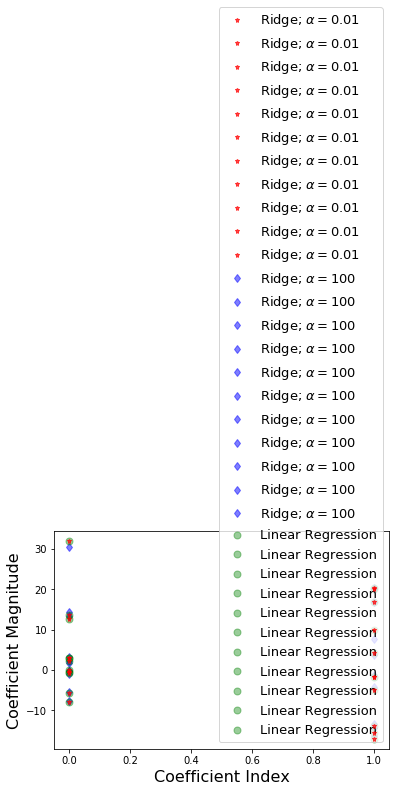

In [82]:
plt.plot(rr.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 0.01$',zorder=7) # zorder for ordering the markers

plt.plot(rr100.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Ridge; $\alpha = 100$') # alpha here is for transparency

plt.plot(lr.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label='Linear Regression')

plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.show()